In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Collect TCR-VALID representations of antigen-labeled TCRs and cluster them

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tcrvalid.load_models import *
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.data_subsetting import *
from tcrvalid.cluster_loop import *
from tcrvalid.defaults import *

(21, 7)
(22, 8)


#### Data and model specificication

Choose to load from_keras to get the model co-packaged with tcr-valid

Model for TRA and TRB to use to get TCR-VALID representations for each chain.
 - here, use the models trained on the full datasets of TRA/TRB chains

In [2]:
from_keras = True #expect True in github code

model_names = {
    'TRA': ['1_2'],
    'TRB': ['1_2_full_40']
}

In [3]:
def get_features(df,trb_model=None,tra_model=None):
    """ Use dataframe of labeled TCRs and TCR-VALID TRA/TRB models to get features
    
    parameters
    -----------
    
    df: pd.DataFrame
        Dataframe of TCRs - expect labeled dataframe for this function. 
        In particular - pre_feature_TRB and/or pre_feature_TRA should be available
        columns containg the sequences to be put through TCR-VALID model. 
        Here those columns contain CDR2-CD3 sequences
        
    trb_model: tf model
        If None, don't include TRB features. Else use representation of this model. If
        tra_model also not None, features from two models are concatenated.
        
    tra_model: tf model
        If None, don't include TRA features. Else use representation of this model. If
        trb_model also not None, features from two models are concatenated. 
    
    """
    if trb_model is not None:
        f_l_trb = mapping.seqs_to_array(df.pre_feature_TRB.values,maxlen=28)
        x_l_trb,_,_ = trb_model.predict(f_l_trb)
    if tra_model is not None:
        f_l_tra = mapping.seqs_to_array(df.pre_feature_TRA.values,maxlen=28)
        x_l_tra,_,_ = tra_model.predict(f_l_tra)

    #y_l = df_labelled.label.values

    if tra_model is not None and trb_model is not None:
        print(x_l_trb.shape)
        print(x_l_tra.shape)
        x_l = np.concatenate([x_l_trb, x_l_tra],axis=1)
    elif tra_model is None:
        x_l = x_l_trb
    elif trb_model is None:
        x_l = x_l_tra
    else:
        raise ValueError()

    return x_l

### Define mapping to phyiscochemical properties and TCR-VALID models

In [4]:
mapping = SeqArrayDictConverter()

loaded_trb_models = load_named_models(model_names['TRB'],chain='TRB',as_keras=from_keras)
loaded_tra_models = load_named_models(model_names['TRA'],chain='TRA',as_keras=from_keras)

tra_model = loaded_tra_models['1_2']
trb_model = loaded_trb_models['1_2_full_40']

2023-05-02 15:14:23.177611: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-02 15:14:23.177653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gen-queue-dy-m58xlarge-1): /proc/driver/nvidia/version does not exist
2023-05-02 15:14:23.178695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load in the antigen-labeled data

 - make_subset() selects for the chosen type of problem
    - here, paired chain, based on CDR2 and CDR3, using 'both' labeled datasets (includes dextramer data)
    - internally removes any duplicates
    
 - get_features() collects TCR-VALID representation for paired-chain TCRs in the dataframe
    

In [5]:
df = pd.read_csv(labelled_data_path)
sources = sources_['both']
chains = chains_['TR']
feature = features_['CDR23']
subset_df = make_subset(df,sources=sources,chains=chains,feature=feature,min_size=3, max_len=28)

x_l = get_features(
  subset_df,
  trb_model=trb_model,
  tra_model=tra_model
)

(4201, 16)
(4201, 16)


#### Cluster TCRs for a range of 'distance thresholds' with DBSCAN

 - set a range of 'epsilon' values for the DBSCAN clustering which sets a distance threshold 
 - Perform clustering on the labeled dataset for these distances and store results in a dataframe 

In [6]:
eps_range = np.linspace(2.0,12.0,10)
scores_df = dbscan_loop(
    subset_df,
    x_l,
    eps_range,
    metric='manhattan',
    min_samples=3,
    eps_format=':.2f'
)

In [7]:
scores_df['epsilon_scaled']=(scores_df['epsilon']-scores_df['epsilon'].min())/(scores_df['epsilon'].max()-scores_df['epsilon'].min())
scores_df=scores_df.rename(columns={"well_clustered_total": "c-CSI","well_clustered": "c-precision"})

#### Take a look at the scores for each threshold

In [8]:
scores_df

,n_clusters,n_epitopes_captured,percent_clustered,percent_clustered_in_largest,percent_labeled_clustered,mean_purity,c-CSI,c-precision,epsilon,epsilon_scaled
eps_2.00,55.0,6.0,11.044989,1.880505,11.044989,99.818182,10.806951,97.844828,2.00,0.000
eps_3.11,63.0,7.0,15.829564,1.951916,15.829564,98.929774,15.662937,98.947368,3.11,0.111
eps_4.22,63.0,8.0,18.400381,4.641752,18.400381,98.386243,17.876696,97.153946,4.22,0.222
eps_5.33,75.0,8.0,21.947155,5.474887,21.947155,97.811111,21.233040,96.746204,5.33,0.333
eps_6.44,73.0,9.0,24.660795,6.046179,24.660795,97.942724,24.160914,97.972973,6.44,0.444
eps_7.56,79.0,10.0,27.683885,9.473935,27.683885,96.109462,26.707927,96.474635,7.56,0.556
eps_8.67,83.0,11.0,31.611521,16.995953,31.611521,95.248369,28.517020,90.210843,8.67,0.667
eps_9.78,89.0,12.0,36.943585,18.757439,36.943585,93.078775,31.183052,84.407216,9.78,0.778
eps_10.89,80.0,12.0,44.108546,33.682457,44.108546,92.622859,7.998096,18.132758,10.89,0.889
eps_12.00,69.0,16.0,51.083075,43.561057,51.083075,94.213364,6.450845,12.628145,12.00,1.000


#### Plot the curve of clustering-Precision vs clustering-CSI

/tmp/ipykernel_13086/3234763028.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes2.set_yticklabels(axes2.get_yticks(), size = 12)
/tmp/ipykernel_13086/3234763028.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes2.set_xticklabels(axes2.get_xticks(), size = 12)


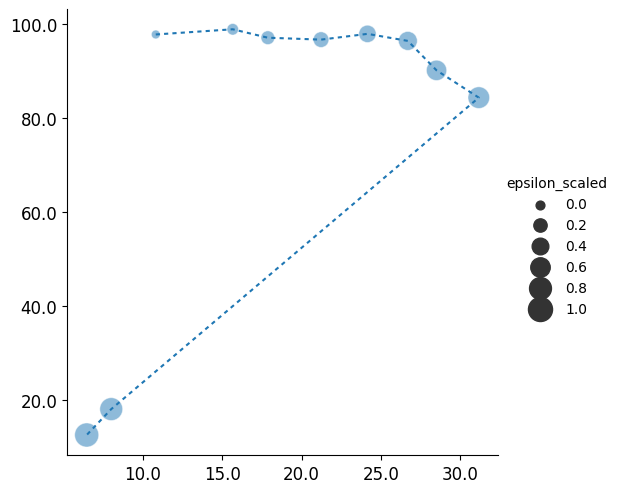

In [9]:
axes=sns.relplot(x='c-CSI', y='c-precision', size='epsilon_scaled',sizes=(40, 300), alpha=.5 ,data=scores_df,legend='brief')
axes2=sns.lineplot(x = 'c-CSI', y = 'c-precision', data = scores_df,sort=False,style=True,dashes=[(2, 2)])
axes2.legend().remove()
axes2.set(xlabel=None)

axes2.set(ylabel=None)
axes2.set_yticklabels(axes2.get_yticks(), size = 12)
axes2.set_xticklabels(axes2.get_xticks(), size = 12)
fig = axes.fig